In [1]:
import pandas as pd
from pathlib import Path
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from citipy import citipy
import hvplot.pandas
from api_keys_mm import weather_api_key
from api_keys_mm import geoapify_key
import os

In [2]:
drugDataDF = pd.read_csv(("drug_deaths.csv"))
pd.set_option('display.max_columns', None)
drugDataDF.head()

,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,DeathCounty,Location,LocationifOther,DescriptionofInjury,InjuryPlace,InjuryCity,InjuryCounty,InjuryState,COD,OtherSignifican,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,MannerofDeath,DeathCityGeo,ResidenceCityGeo,InjuryCityGeo
0,0,14-0273,06/28/2014 12:00:00 AM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,substance,NaN,NaN,NaN,NaN,"Acute fent, hydrocod, benzodiazepine",NaN,0,0,1,0.0,0,0,0,1,1,0,0,0,0,0,NaN,0,0,Accident,"CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)"
1,1,13-0102,03/21/2013 12:00:00 AM,0.0,48.0,Male,Black,NORWALK,NaN,NaN,NORWALK,FAIRFIELD,Hospital,NaN,NaN,NaN,NaN,NaN,NaN,Cocaine Intoxication,NaN,0,1,0,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,Accident,"Norwalk, CT\n(41.11805, -73.412906)","NORWALK, CT\n(41.11805, -73.412906)","CT\n(41.575155, -72.738288)"
2,2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,Hospital,NaN,Substance Abuse,Unknown,UNKNOWN,NaN,NaN,Acute Heroin and Cocaine Intoxication,NaN,1,1,0,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,Accident,"Danbury, CT\n(41.393666, -73.451539)","SANDY HOOK, CT\n(41.419998, -73.282501)",NaN
3,3,16-0208,03/31/2016 12:00:00 AM,0.0,23.0,Male,White,RYE,WESTCHESTER,NY,GREENWICH,NaN,Hospital,NaN,substance abuse,Residence,RYE,NaN,NaN,Acute Fentanyl and Morphine Intoxication,NaN,1,0,1,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,NaN
4,4,13-0052,02/13/2013 12:00:00 AM,0.0,22.0,Male,"Asian, Other",FLUSHING,QUEENS,NaN,GREENWICH,FAIRFIELD,Hospital,NaN,Transdermal Absorption,Other,NaN,NaN,NaN,Fentanyl Intoxication,NaN,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,"CT\n(41.575155, -72.738288)"


In [3]:
drugColDF = drugDataDF[['ID', 'Date', 'DateType', 'Age', 'Sex', 'Race',
       'ResidenceCity', 'ResidenceCounty', 'ResidenceState', 'DeathCity',
       'InjuryState', 'Heroin', 'Cocaine', 'Fentanyl', 'Fentanyl_Analogue',
       'Oxycodone', 'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine',
       'Methadone', 'Amphet', 'Tramad', 'Morphine_NotHeroin', 'Hydromorphone',
       'Other', 'OpiateNOS', 'AnyOpioid', 'DeathCityGeo']]
drugColDF.head()

,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,InjuryState,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,DeathCityGeo
0,14-0273,06/28/2014 12:00:00 AM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0,0,0,1,1,0,0,0,0,0,NaN,0,0,"CT\n(41.575155, -72.738288)"
1,13-0102,03/21/2013 12:00:00 AM,0.0,48.0,Male,Black,NORWALK,NaN,NaN,NORWALK,NaN,0,1,0,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,"Norwalk, CT\n(41.11805, -73.412906)"
2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,1,1,0,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Danbury, CT\n(41.393666, -73.451539)"
3,16-0208,03/31/2016 12:00:00 AM,0.0,23.0,Male,White,RYE,WESTCHESTER,NY,GREENWICH,NaN,1,0,1,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Greenwich, CT\n(41.026526, -73.628549)"
4,13-0052,02/13/2013 12:00:00 AM,0.0,22.0,Male,"Asian, Other",FLUSHING,QUEENS,NaN,GREENWICH,NaN,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,"Greenwich, CT\n(41.026526, -73.628549)"


In [4]:
drugLocDF = drugColDF.loc[drugColDF["ResidenceState"] == "CT"]
drugLocDF = drugLocDF.loc[drugColDF["Sex"] != "Unknown"]
drugLocDF = drugLocDF.loc[drugColDF["Race"] != "Unknown"]

drugLocDF["Fentanyl"] = drugLocDF["Fentanyl"].replace("1-A","1")
drugLocDF["Morphine_NotHeroin"] = drugLocDF["Morphine_NotHeroin"].replace(["1ES","STOLE MEDS", "NO RX BUT STRAWS","PCP NEG"],0)
drugLocDF["Morphine_NotHeroin"] = drugLocDF["Morphine_NotHeroin"].astype(int)
drugLocDF["Fentanyl_Analogue"] = drugLocDF["Fentanyl_Analogue"].astype(int)
drugLocDF["Fentanyl"] = drugLocDF["Fentanyl"].astype(int)


drugLocDF.head()

,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,InjuryState,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,DeathCityGeo
2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Danbury, CT\n(41.393666, -73.451539)"
13,15-0232,05/14/2015 12:00:00 AM,1.0,50.0,Male,White,DANBURY,FAIRFIELD,CT,DANBURY,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"DANBURY, CT\n(41.393666, -73.451539)"
14,16-0028,01/13/2016 12:00:00 AM,0.0,29.0,Male,Black,NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,NaN,1,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,0,1,"NEW HAVEN, CT\n(41.308252, -72.924161)"
18,16-0065,01/30/2016 12:00:00 AM,0.0,54.0,Male,White,MIDDLETOWN,MIDDLESEX,CT,MIDDLETOWN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,1,"MIDDLETOWN, CT\n(41.544654, -72.651713)"
19,16-0889,12/20/2016 12:00:00 AM,0.0,32.0,Male,White,WINDHAM,WINDHAM,CT,WINDHAM,NaN,1,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,0,1,"Windham, CT\n(41.699744, -72.157703)"


In [5]:
drugLocDF.to_csv("drug_deaths_clean.csv")

In [6]:
Heroin = drugLocDF["Heroin"].sum()
Cocaine = drugLocDF["Cocaine"].sum()
Fentanyl = drugLocDF["Fentanyl"].sum()
Fentanyl_Analogue = drugLocDF["Fentanyl_Analogue"].sum()
Oxycodone = drugLocDF["Oxycodone"].sum()
Oxymorphone = drugLocDF["Oxymorphone"].sum()
Ethanol = drugLocDF["Ethanol"].sum()
Hydrocodone = drugLocDF["Hydrocodone"].sum()
Benzodiazepine = drugLocDF["Benzodiazepine"].sum()
Methadone = drugLocDF["Methadone"].sum()
Amphet = drugLocDF["Amphet"].sum()
Tramad = drugLocDF["Tramad"].sum()
Morphine_NotHeroin = drugLocDF["Morphine_NotHeroin"].sum()
Hydromorphone = drugLocDF["Hydromorphone"].sum()
OpiateNOS = drugLocDF["OpiateNOS"].sum()



drug_stats = pd.DataFrame({"Heroin":[Heroin],
                          "Cocaine":[Cocaine],
                          "Fentanyl":[Fentanyl],
                          "Oxycodone":[Oxycodone],
                          "Oxymorphone":[Oxymorphone],
                          "Ethanol":[Ethanol],
                          "Hydrocodone":[Hydrocodone],
                          "Benzodiazepine":[Benzodiazepine],
                          "Methadone":[Methadone],
                          "Amphet":[Amphet],
                          "Tramad":[Tramad],
                          "Morphine":[Morphine_NotHeroin],
                          "Hydromorphone":[Hydromorphone],
                          "OpiateNOS":[OpiateNOS],
                         })
drug_stats

,Heroin,Cocaine,Fentanyl,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine,Hydromorphone,OpiateNOS
0,1643,1022,1933,345,31,901,66,992,324,124,93,34,21,82


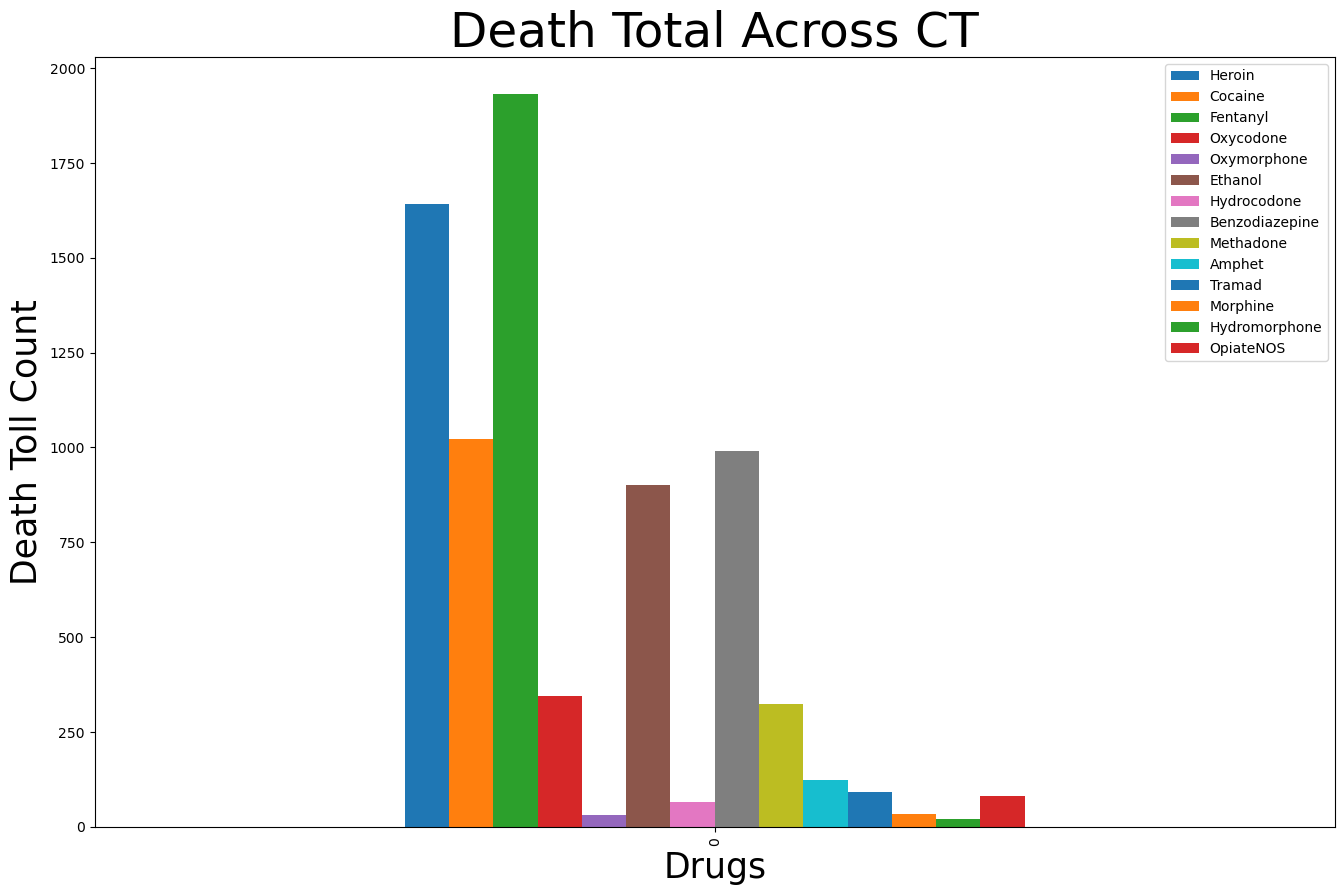

In [7]:

plot_pandas = drug_stats.plot(kind="bar", linewidth=1, figsize=(16, 10)) 
plt.xlabel("Drugs", fontsize = 25)
plt.ylabel("Death Toll Count", fontsize = 25)
plt.title("Death Total Across CT", fontsize = 35)

plt.savefig("Images/DeathTotalBarGraph.png")

plt.show()

In [8]:
# import drug_death_clean.csv 
drug1DF = pd.read_csv(("../Data Cleaning/drug_deaths_clean.csv"))
pd.set_option('display.max_columns', None)
drugDF = drug1DF[['ID', 'Date', 'DateType', 'Age', 'Sex', 'Race',
       'ResidenceCity', 'ResidenceCounty', 'ResidenceState', 'DeathCity',
       'InjuryState', 'Heroin', 'Cocaine', 'Fentanyl', 'Fentanyl_Analogue',
       'Oxycodone', 'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine',
       'Methadone', 'Amphet', 'Tramad', 'Morphine_NotHeroin', 'Hydromorphone',
       'Other', 'OpiateNOS', 'AnyOpioid', 'DeathCityGeo']]
drugDF.head()

,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,InjuryState,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,DeathCityGeo
0,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Danbury, CT\n(41.393666, -73.451539)"
1,15-0232,05/14/2015 12:00:00 AM,1.0,50.0,Male,White,DANBURY,FAIRFIELD,CT,DANBURY,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"DANBURY, CT\n(41.393666, -73.451539)"
2,16-0028,01/13/2016 12:00:00 AM,0.0,29.0,Male,Black,NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,NaN,1,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,0,1,"NEW HAVEN, CT\n(41.308252, -72.924161)"
3,16-0065,01/30/2016 12:00:00 AM,0.0,54.0,Male,White,MIDDLETOWN,MIDDLESEX,CT,MIDDLETOWN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,1,"MIDDLETOWN, CT\n(41.544654, -72.651713)"
4,16-0889,12/20/2016 12:00:00 AM,0.0,32.0,Male,White,WINDHAM,WINDHAM,CT,WINDHAM,NaN,1,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,0,1,"Windham, CT\n(41.699744, -72.157703)"


In [9]:
# break dates down into lists
dates = []
year = []
month = []
day = []

for x in range(len(drugDF.index)):
    dates.append(drugDF['Date'][x].split()[0])
    year.append(drugDF['Date'][x].split()[0].split('/')[2])
    month.append(drugDF['Date'][x].split()[0].split('/')[0])
    day.append(drugDF['Date'][x].split()[0].split('/')[1])
    #print(f'{month[x]} {day[x]} {year[x]} | {dates[x]}')

In [10]:
# create a data frame for new date variables
dateDF = pd.DataFrame({'Date':dates,
                       'Month':month,
                       'Day':day,
                       'Year':year,
                       'Season':''})
dateDF

,Date,Month,Day,Year,Season
0,03/13/2016,03,13,2016,
1,05/14/2015,05,14,2015,
2,01/13/2016,01,13,2016,
3,01/30/2016,01,30,2016,
4,12/20/2016,12,20,2016,
...,...,...,...,...,...
3420,12/02/2017,12,02,2017,
3421,01/07/2015,01,07,2015,
3422,09/08/2015,09,08,2015,
3423,07/22/2017,07,22,2017,


In [11]:
# assign seasons to date dataframe
for x in range(len(dateDF.index)):
    if dateDF['Month'][x] == '03' or dateDF['Month'][x] == '04' or dateDF['Month'][x] == '05':
        dateDF['Season'][x] = 'Spring'
    elif dateDF['Month'][x] == '06' or dateDF['Month'][x] == '07' or dateDF['Month'][x] == '08':
        dateDF['Season'][x] = 'Summer'
    elif dateDF['Month'][x] == '09' or dateDF['Month'][x] == '10' or dateDF['Month'][x] == '11':
        dateDF['Season'][x] = 'Autumn'
    elif dateDF['Month'][x] == '12' or dateDF['Month'][x] == '01' or dateDF['Month'][x] == '02':
        dateDF['Season'][x] = 'Winter'
    else:
        dateDF['Season'][x] = 'N/A'
dateDF

,Date,Month,Day,Year,Season
0,03/13/2016,03,13,2016,Spring
1,05/14/2015,05,14,2015,Spring
2,01/13/2016,01,13,2016,Winter
3,01/30/2016,01,30,2016,Winter
4,12/20/2016,12,20,2016,Winter
...,...,...,...,...,...
3420,12/02/2017,12,02,2017,Winter
3421,01/07/2015,01,07,2015,Winter
3422,09/08/2015,09,08,2015,Autumn
3423,07/22/2017,07,22,2017,Summer


In [12]:
# create dataframe for each season
SpringDF = dateDF.loc[dateDF['Season'] == 'Spring']
SummerDF = dateDF.loc[dateDF['Season'] == 'Summer']
AutumnDF = dateDF.loc[dateDF['Season'] == 'Autumn']
WinterDF = dateDF.loc[dateDF['Season'] == 'Winter']

In [13]:
SpringDF['Year'] = pd.to_numeric(SpringDF['Year'])
SummerDF['Year'] = pd.to_numeric(SummerDF['Year'])
AutumnDF['Year'] = pd.to_numeric(AutumnDF['Year'])
WinterDF['Year'] = pd.to_numeric(WinterDF['Year'])
SpringDF.sort_values(by=['Year'])
SummerDF.sort_values(by=['Year'])
AutumnDF.sort_values(by=['Year'])
WinterDF.sort_values(by=['Year'])

C:\Users\AzureDemise\AppData\Local\Temp\ipykernel_2316\663677240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpringDF['Year'] = pd.to_numeric(SpringDF['Year'])
C:\Users\AzureDemise\AppData\Local\Temp\ipykernel_2316\663677240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SummerDF['Year'] = pd.to_numeric(SummerDF['Year'])
C:\Users\AzureDemise\AppData\Local\Temp\ipykernel_2316\663677240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,Date,Month,Day,Year,Season
3421,01/07/2015,01,07,2015,Winter
2306,01/08/2015,01,08,2015,Winter
649,01/06/2015,01,06,2015,Winter
651,02/05/2015,02,05,2015,Winter
2286,02/06/2015,02,06,2015,Winter
...,...,...,...,...,...
2237,02/01/2018,02,01,2018,Winter
2232,02/18/2018,02,18,2018,Winter
2223,12/24/2018,12,24,2018,Winter
2213,02/13/2018,02,13,2018,Winter


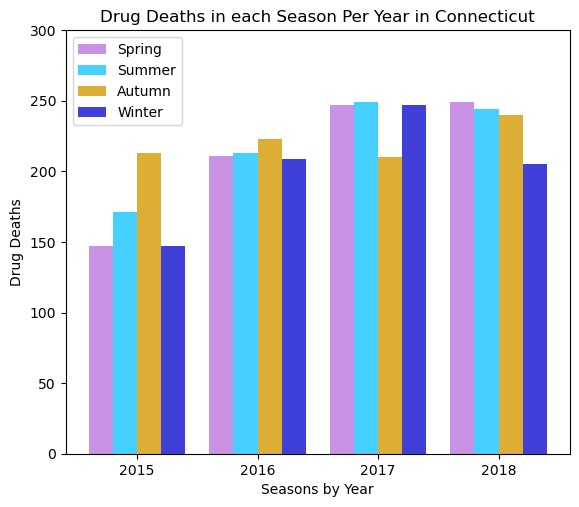

In [14]:
#assign color values
purple = clr.to_rgba('darkorchid', alpha=0.53)
lBlue = clr.to_rgba('deepskyblue', alpha=0.73)
dBlue = clr.to_rgba('mediumblue', alpha=0.75)
gold = clr.to_rgba('goldenrod', alpha=0.9)
colors = [purple, lBlue, gold, dBlue]
x = np.arange(2014.5,2019,1)

#plot and label histogram
plt.figure(figsize=(6.5,5.5))
plt.hist([SpringDF['Year'], SummerDF['Year'], AutumnDF['Year'], WinterDF['Year']],
         label=['Spring', 'Summer', 'Autumn', 'Winter'], color = colors,bins = x)

plt.xticks([2015, 2016, 2017, 2018])
plt.ylim(-0, 300)
plt.title("Drug Deaths in each Season Per Year in Connecticut")
plt.xlabel("Seasons by Year")
plt.ylabel("Drug Deaths")
plt.legend(loc="upper left")
plt.savefig("Images/SeasonsHistogram.png")

  Per_Year  counts
3     2015     678
2     2016     856
0     2017     953
1     2018     938


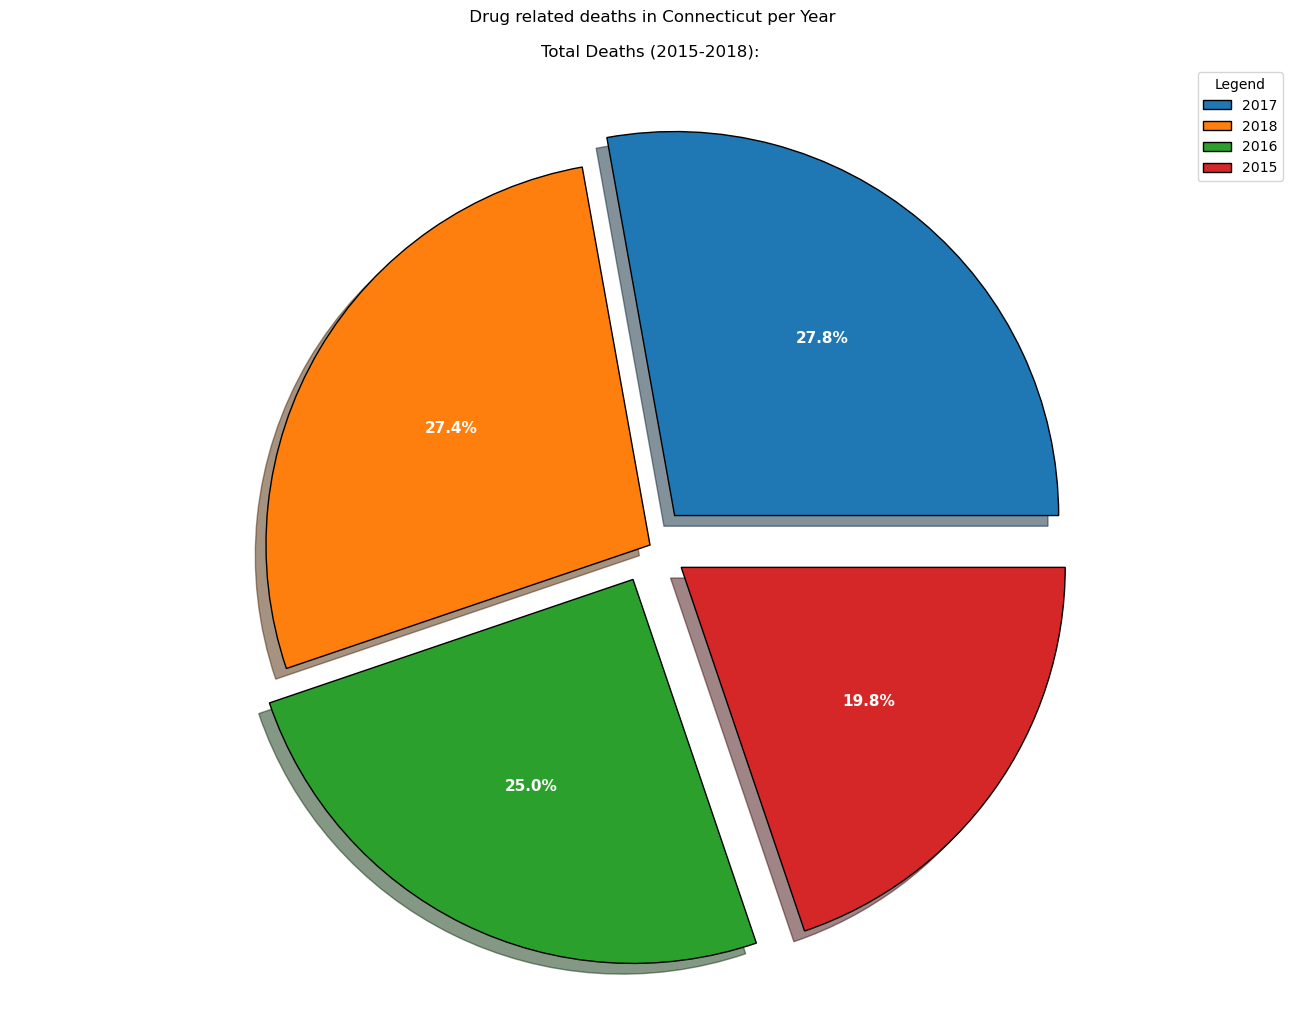

Death Increase from 2015 to 2016 is 26.253687315634217%
Death Increase from 2016 to 2017 is 11.33177570093458%
Death Increase from 2017 to 2018 is -1.5739769150052465%
Death Increase from 2015 to 2018 is 38.34808259587021%


In [15]:
#Create Death Per Year DF
#Set index and rename column value 
Total_Death_perYear_DF = dateDF["Year"].value_counts().rename_axis("Per_Year").reset_index(name='counts')

Total = Total_Death_perYear_DF.sort_values("Per_Year" )

print(Total)
#print (Total_Death_perYear_DF['counts']).value_counts()
labels = Total_Death_perYear_DF.Per_Year
values = Total_Death_perYear_DF.counts
explode = [0.1,0,0.1,0.1,] # explode is = to the number of  index from the count of the key value

#visualize the pie chart
fig = plt.figure()
ax =fig.add_axes([0,0,2,2])
ax.axis('equal')
ax.pie(values, labels = labels, autopct="%1.1f%%", explode = explode,
       textprops={'fontsize':11, 'weight': 'bold', 'color': 'white'},
       wedgeprops = {'edgecolor': 'black'},shadow=True)
plt.title(f" Drug related deaths in Connecticut per Year\n\nTotal Deaths (2015-2018):")
plt.legend(labels, title = "Legend", loc="best")
plt.savefig("Images/racechart.png", bbox_inches = 'tight')
plt.savefig("Images/DeathPerYearPie.png", bbox_inches = 'tight')
plt.show()

Percent_year2016 = (((Total['counts'][2]) -(Total['counts'][3]))/(Total['counts'][3]))*100
Percent_year2017 = (((Total['counts'][0]) -(Total['counts'][2]))/(Total['counts'][2]))*100
Percent_year2018 = (((Total['counts'][1]) -(Total['counts'][0]))/(Total['counts'][0]))*100
Percent_year15_18 = (((Total['counts'][1]) -(Total['counts'][3]))/(Total['counts'][3]))*100
print(f"Death Increase from 2015 to 2016 is {Percent_year2016}%")
print(f"Death Increase from 2016 to 2017 is {Percent_year2017}%")
print(f"Death Increase from 2017 to 2018 is {Percent_year2018}%")
print(f"Death Increase from 2015 to 2018 is {Percent_year15_18}%")


In [16]:
#create new DF with the count of each category
Death_by_race_count =drugLocDF["Race"].value_counts()
Death_by_race_count

White              2689
Hispanic, White     379
Black               300
Hispanic, Black      17
Asian Indian         13
Asian, Other         12
Other                 6
Chinese               2
Hawaiian              1
Name: Race, dtype: int64

In [17]:
#Create Race DF
#Set index and rename column value 
Death_by_race_count = drugLocDF["Race"].value_counts().rename_axis("sub_race_values").reset_index(name='counts')
Death_by_race_count

,sub_race_values,counts
0,White,2689
1,"Hispanic, White",379
2,Black,300
3,"Hispanic, Black",17
4,Asian Indian,13
5,"Asian, Other",12
6,Other,6
7,Chinese,2
8,Hawaiian,1


In [18]:
#Combined_other_race = race_df.replace(Asian Indian, np.Other, inplace = True)
Combined_other_race_df= Death_by_race_count
Combined_other_race_df['sub_race_values'] = Combined_other_race_df['sub_race_values'].replace(['Asian Indian','Asian, Other','Other','Chinese','Hawaiian','Hispanic, Black','Hispanic, White' ],['Asian and Some Other','Asian and Some Other','Asian and Some Other','Asian and Some Other','Asian and Some Other','Hispanic','Hispanic'])
combined_race_df = Combined_other_race_df.groupby('sub_race_values',as_index = False).agg('sum')

#df.reset.index(as_index = False).groupby(as_index = False).sum()
print(combined_race_df)
combined_race_df

        sub_race_values  counts
0  Asian and Some Other      34
1                 Black     300
2              Hispanic     396
3                 White    2689


,sub_race_values,counts
0,Asian and Some Other,34
1,Black,300
2,Hispanic,396
3,White,2689


In [19]:
#taking the total of counts column to get the value out of the percentage
total_death_counts = combined_race_df.counts.sum()
total_death_counts

3419

In [20]:
# to add the values along with percentage we have to do reverse calculations using a function
#
def my_autopct_function(prct_value):
    (prct_value)
    return'{:.0f}%\n{:.0f} deaths'.format(prct_value, total_death_counts*prct_value/100)

In [21]:
#set labels and values to display in pie chart
labels = combined_race_df.sub_race_values
values = combined_race_df.counts
explode = [0.1,0,0.1,0.1,] # explode is = to the number of  index from the count of the key value


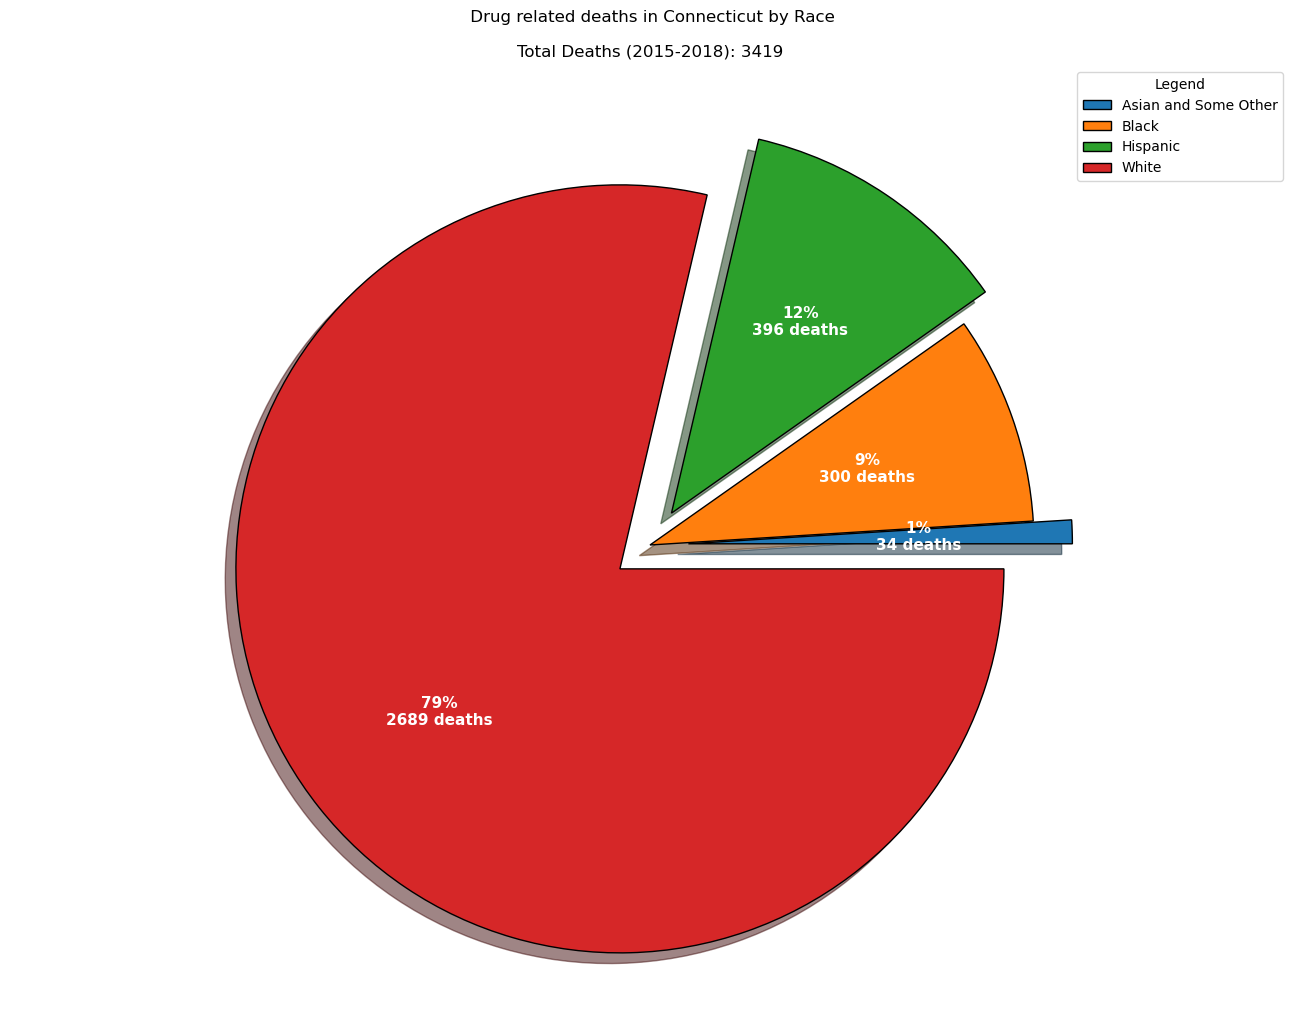

In [22]:
#visualize the pie chart
fig = plt.figure()
ax =fig.add_axes([0,0,2,2])
ax.axis('equal')
ax.pie(values, autopct = my_autopct_function, explode = explode,
       textprops={'fontsize':11, 'weight': 'bold', 'color': 'white'},
       wedgeprops = {'edgecolor': 'black'},shadow=True)
plt.title(f" Drug related deaths in Connecticut by Race\n\nTotal Deaths (2015-2018): {total_death_counts}")
plt.legend(labels, title = "Legend", loc="best")
plt.savefig("Images/racechart.png", bbox_inches = 'tight')
plt.show()
#autopct function returns List of strings used to Label the wedge with their numerical value
#explode - List the margin in the sequence of data 


In [23]:
#read cleaned data from CSV file in folder
clean_data = pd.read_csv(("drug_deaths_clean.csv"))
pd.set_option('display.max_columns', None)
clean_data.info()
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3425 non-null   int64  
 1   ID                  3425 non-null   object 
 2   Date                3425 non-null   object 
 3   DateType            3425 non-null   float64
 4   Age                 3425 non-null   float64
 5   Sex                 3422 non-null   object 
 6   Race                3419 non-null   object 
 7   ResidenceCity       3425 non-null   object 
 8   ResidenceCounty     3383 non-null   object 
 9   ResidenceState      3425 non-null   object 
 10  DeathCity           3425 non-null   object 
 11  InjuryState         1318 non-null   object 
 12  Heroin              3425 non-null   int64  
 13  Cocaine             3425 non-null   int64  
 14  Fentanyl            3425 non-null   int64  
 15  Fentanyl_Analogue   3425 non-null   int64  
 16  Oxycod

,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,InjuryState,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,DeathCityGeo
0,2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Danbury, CT\n(41.393666, -73.451539)"
1,13,15-0232,05/14/2015 12:00:00 AM,1.0,50.0,Male,White,DANBURY,FAIRFIELD,CT,DANBURY,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"DANBURY, CT\n(41.393666, -73.451539)"
2,14,16-0028,01/13/2016 12:00:00 AM,0.0,29.0,Male,Black,NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,NaN,1,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,0,1,"NEW HAVEN, CT\n(41.308252, -72.924161)"
3,18,16-0065,01/30/2016 12:00:00 AM,0.0,54.0,Male,White,MIDDLETOWN,MIDDLESEX,CT,MIDDLETOWN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,1,"MIDDLETOWN, CT\n(41.544654, -72.651713)"
4,19,16-0889,12/20/2016 12:00:00 AM,0.0,32.0,Male,White,WINDHAM,WINDHAM,CT,WINDHAM,NaN,1,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,0,1,"Windham, CT\n(41.699744, -72.157703)"


In [24]:
#I noticed in code below when I tried to combine drug types, Fentanyl column is a string. See output below for why
#Turns out several drug types are strings. See df.info() above for which ones
print(clean_data["Fentanyl"].value_counts())
clean_data["Morphine_NotHeroin"].value_counts()

1    1933
0    1492
Name: Fentanyl, dtype: int64


0    3391
1      34
Name: Morphine_NotHeroin, dtype: int64

In [25]:
#replace weird value with 1 so I cann add columns together
clean_data["Fentanyl"] = clean_data["Fentanyl"].replace(["1-A", " "],"1")
clean_data["Morphine_NotHeroin"] = clean_data["Morphine_NotHeroin"].replace(["1ES","STOLE MEDS", " ", "NO RX BUT STRAWS","PCP NEG"],0)


clean_data["Fentanyl"].value_counts()
clean_data["Morphine_NotHeroin"].value_counts()

0    3391
1      34
Name: Morphine_NotHeroin, dtype: int64

In [26]:
#reformat all changed string columns as integers
clean_data["Fentanyl"] = clean_data["Fentanyl"].astype(int)
clean_data["Morphine_NotHeroin"] = clean_data["Morphine_NotHeroin"].astype(int)
clean_data["Fentanyl_Analogue"] = clean_data["Fentanyl_Analogue"].astype(int)
clean_data.head()

,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,InjuryState,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,DeathCityGeo
0,2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Danbury, CT\n(41.393666, -73.451539)"
1,13,15-0232,05/14/2015 12:00:00 AM,1.0,50.0,Male,White,DANBURY,FAIRFIELD,CT,DANBURY,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"DANBURY, CT\n(41.393666, -73.451539)"
2,14,16-0028,01/13/2016 12:00:00 AM,0.0,29.0,Male,Black,NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,NaN,1,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,0,1,"NEW HAVEN, CT\n(41.308252, -72.924161)"
3,18,16-0065,01/30/2016 12:00:00 AM,0.0,54.0,Male,White,MIDDLETOWN,MIDDLESEX,CT,MIDDLETOWN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,1,"MIDDLETOWN, CT\n(41.544654, -72.651713)"
4,19,16-0889,12/20/2016 12:00:00 AM,0.0,32.0,Male,White,WINDHAM,WINDHAM,CT,WINDHAM,NaN,1,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,0,1,"Windham, CT\n(41.699744, -72.157703)"


In [27]:
clean_data["Total Drug Deaths"] = clean_data["Heroin"] + clean_data["Cocaine"] + clean_data["Fentanyl"] + clean_data["Fentanyl_Analogue"] + clean_data["Oxycodone"] + clean_data["Oxymorphone"] + clean_data["Ethanol"] + clean_data["Hydrocodone"] + clean_data["Benzodiazepine"] + clean_data["Methadone"] + clean_data["Amphet"] + clean_data["Tramad"] + clean_data["Morphine_NotHeroin"]
clean_data.head()

,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,InjuryState,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,DeathCityGeo,Total Drug Deaths
0,2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Danbury, CT\n(41.393666, -73.451539)",2
1,13,15-0232,05/14/2015 12:00:00 AM,1.0,50.0,Male,White,DANBURY,FAIRFIELD,CT,DANBURY,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"DANBURY, CT\n(41.393666, -73.451539)",1
2,14,16-0028,01/13/2016 12:00:00 AM,0.0,29.0,Male,Black,NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,NaN,1,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,0,1,"NEW HAVEN, CT\n(41.308252, -72.924161)",3
3,18,16-0065,01/30/2016 12:00:00 AM,0.0,54.0,Male,White,MIDDLETOWN,MIDDLESEX,CT,MIDDLETOWN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,1,"MIDDLETOWN, CT\n(41.544654, -72.651713)",2
4,19,16-0889,12/20/2016 12:00:00 AM,0.0,32.0,Male,White,WINDHAM,WINDHAM,CT,WINDHAM,NaN,1,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,0,1,"Windham, CT\n(41.699744, -72.157703)",3


In [28]:
#Use weather API to extract latitude and longitude data for each city to use for HVPLOT
#test weather API call for 1 city to make sure it works

# Set the API base URL
base_url = "http://api.openweathermap.org/data/2.5/weather?"


# Create endpoint URL with each city, testing it with 2nd city in list
city_url = base_url + "appid=" + weather_api_key + "&q=" + "Middletown"
response = requests.get(city_url).json()
pprint(response)

{'base': 'stations',
 'clouds': {'all': 100},
 'cod': 200,
 'coord': {'lat': 39.5151, 'lon': -84.3983},
 'dt': 1692224787,
 'id': 4518264,
 'main': {'feels_like': 298.3,
          'humidity': 66,
          'pressure': 1012,
          'temp': 298.03,
          'temp_max': 299.77,
          'temp_min': 296.62},
 'name': 'Middletown',
 'sys': {'country': 'US',
         'id': 2000186,
         'sunrise': 1692183054,
         'sunset': 1692232392,
         'type': 2},
 'timezone': -14400,
 'visibility': 10000,
 'weather': [{'description': 'overcast clouds',
              'icon': '04d',
              'id': 804,
              'main': 'Clouds'}],
 'wind': {'deg': 160, 'speed': 1.54}}


In [29]:
#Grouping by city to condense rows and make for loop below go much faster. 3425 rows -> 207 rows
groupby_city = clean_data.groupby(["DeathCity"]).sum()


C:\Users\AzureDemise\AppData\Local\Temp\ipykernel_2316\2646773853.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby_city = clean_data.groupby(["DeathCity"]).sum()


In [30]:
#use for loop to loop through cities and extract latitude and longitude for each city

#define empty list to append lat and lng data into
lat = []
lng = []

#loop through city list and extract lat and lng for each city, and append them to their respective list. groupby_city.index is the city name
for city in groupby_city.index:
    print(city)
    
    #define base URL
    base_url = "http://api.openweathermap.org/data/2.5/weather?"


    # Create endpoint URL with each city, testing it with 2nd city in list
    city_url = base_url + "appid=" + weather_api_key + "&q=" + city
    response = requests.get(city_url).json()
    
    #need try/except statment if not lat/lng data is available.
    try:
        lat.append(response["coord"]["lat"])
        lng.append(response["coord"]["lon"])
        
    #need to fill in null value in lat & lng lists if no data is there because the list length has to be the same as DF length to add the lists to the DF
    except:
        print("No coordinates available")
        #lat.append(np.nan) #putting in null values stops plot from running. Put in 0 and filter them out later
        lat.append(0)
        lng.append(0)

groupby_city["Latitude"] = lat
groupby_city["Longitude"] = lng
groupby_city

6340
AMSTON
ANDOVER
ANSONIA
ASHFORD
AVON
BAKERSVILLE
BALTIC
BANTAM
BEACON FALLS
BERLIN
BETHANY
BETHEL
BETHLEHEM
BLOOMFIELD
BOLTON
BRANFORD
BRIDGEPORT
BRIDGEWATER
BRISTOL
BROAD BROOK
BROOKFIELD
BROOKLYN
BURLINGTON
CANTERBURY
CANTON
CENTRAL VILLAGE
CHAPLIN
CHESHIRE
CHESTER
CLINTON
COLCHESTER
COLUMBIA
CORNWALL BRIDGE
COS COB
COVENTRY
CROMWELL
DANBURY
DANIELSON
DARIEN
DAYVILLE
DEEP RIVER
DERBY
DURHAM
EAST CANAAN
EAST GRANBY
EAST HADDAM
EAST HAMPTON
EAST HARTFORD
EAST HAVEN
EAST LYME
No coordinates available
EAST WINDSOR
EASTFORD
EASTON
ELLINGTON
ENFIELD
ESSEX
FAIRFIELD
FARMINGTON
FRANKLIN
GALES FERRY
GLASTONBURY
GOSHEN
GRANBY
GREENWICH
GRISWOLD
GROTON
GROTON LONG POINT
GUILFORD
HADDAM
HAMDEN
HAMPTON
HANOVER
HARTFORD
HARWINTON
HEBRON
HIGGANUM
IVORYTON
JEWETT CITY
KENT
KILLINGLY
No coordinates available
KILLINGWORTH
LEBANON
LEDYARD
LISBON
LITCHFIELD
MADISON
MANCHESTER
MANSFIELD
MARLBOROUGH
MASHANTUCKET
No coordinates available
MERIDEN
MIDDLEBURY
MIDDLEFIELD
MIDDLETOWN
MILFORD
MONROE
MONTVILL

,Unnamed: 0,DateType,Age,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,OpiateNOS,Total Drug Deaths,Latitude,Longitude
DeathCity,,,,,,,,,,,,,,,,,,,,,
6340,4848,1.0,51.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,3,24.5954,88.2705
AMSTON,4558,1.0,32.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,41.6254,-72.3431
ANDOVER,6936,1.0,91.0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,4,51.2083,-1.4825
ANSONIA,51107,10.0,686.0,4,4,6,1,5,0,4,0,6,4,1,0,1,0,0,36,41.3462,-73.0790
ASHFORD,14060,5.0,181.0,3,4,3,1,0,0,3,0,2,0,1,0,0,0,0,17,51.1459,0.8728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WINSTED,16254,6.0,207.0,5,1,3,0,0,0,1,0,1,2,1,0,1,0,1,15,41.9212,-73.0601
WOLCOTT,2290,1.0,83.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,3,41.6023,-72.9868
WOODBRIDGE,6434,2.0,107.0,2,0,1,0,1,0,0,0,2,0,0,1,0,0,0,7,40.5576,-74.2846


In [31]:
# Configure the map plot
map1 = groupby_city.hvplot.points("Longitude","Latitude", geo=True, tiles="OSM", 
                                  frame_width = 700, frame_height = 500,
                                  size = "Total Drug Deaths")
map1

C:\Users\AzureDemise\anaconda3\envs\dev\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Total Drug Deaths)

In [32]:
#filter out areas that are not Connecticut.
groupby_city["Total Drug Deaths"].sum() #there are 7857 total deaths. Use as reference to see how many are cut out

#filter out cities outside this region. Weather.py picked up some cities with the same name in another part of the world
groupby_city_filtered = groupby_city.loc[(groupby_city["Latitude"]>40) & 
                                         (groupby_city["Latitude"]<43) & 
                                         (groupby_city["Longitude"]>-80)]

groupby_city_filtered["Total Drug Deaths"].sum() #narrowed it from 7857 cities down to 6080 cities
groupby_city_filtered.reset_index()

,DeathCity,Unnamed: 0,DateType,Age,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,OpiateNOS,Total Drug Deaths,Latitude,Longitude
0,AMSTON,4558,1.0,32.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,41.6254,-72.3431
1,ANSONIA,51107,10.0,686.0,4,4,6,1,5,0,4,0,6,4,1,0,1,0,0,36,41.3462,-73.0790
2,BALTIC,1433,1.0,79.0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,4,41.6170,-72.0845
3,BEACON FALLS,4804,2.0,147.0,2,0,2,1,0,0,0,0,2,0,0,0,0,0,0,7,41.4429,-73.0626
4,BETHEL,14512,2.0,211.0,2,2,5,0,1,1,0,0,2,0,0,0,0,0,0,13,41.3712,-73.4140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,WINDHAM,16963,4.0,302.0,6,2,4,0,1,0,0,0,1,0,0,0,1,0,0,15,41.8334,-72.0001
100,WINDSOR LOCKS,44867,11.0,562.0,5,2,8,0,0,0,4,0,4,1,0,0,0,0,0,24,41.9293,-72.6273
101,WINSTED,16254,6.0,207.0,5,1,3,0,0,0,1,0,1,2,1,0,1,0,1,15,41.9212,-73.0601
102,WOLCOTT,2290,1.0,83.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,3,41.6023,-72.9868


In [33]:
#need to copy death city column to color points by city and lebel them because DeathCity is the index and I can't figure out how to color by index
groupby_city_filtered["DeathCity"] = groupby_city_filtered.index

C:\Users\AzureDemise\AppData\Local\Temp\ipykernel_2316\381661874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupby_city_filtered["DeathCity"] = groupby_city_filtered.index


In [34]:
map2 = groupby_city_filtered.hvplot.points("Longitude","Latitude", geo=True, tiles="OSM", 
                                  frame_width = 700, frame_height = 500,
                                  size = "Total Drug Deaths", 
                                  color = "DeathCity")
map2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (DeathCity,Total Drug Deaths)

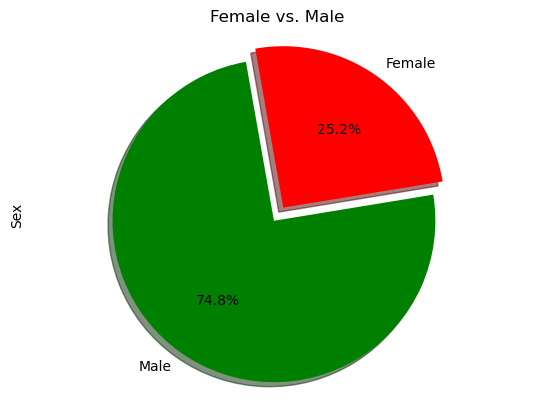

In [35]:
colors=['green', 'red']
explode = (0.1, 0)
gender_data = drugLocDF["Sex"].value_counts()
plt.title("Female vs. Male")
gender_data.plot.pie(colors=colors, autopct="%1.1f%%", explode=explode, shadow=True, startangle=100)
plt.axis("equal")
plt.savefig("Images/FemaleVsMalePie.png")
plt.show()

In [36]:
#read drug overdose data in 
drug_deaths = pd.read_csv(("drug_deaths_clean.csv"))
drug_deaths = drug_deaths.loc[(drug_deaths["Fentanyl"] != " ")]
drug_deaths["Fentanyl"] = drug_deaths["Fentanyl"].replace(["1-A"],"1")

print(drug_deaths.shape)
print(drug_deaths.columns)
drug_deaths.head()

(3425, 30)
Index(['Unnamed: 0', 'ID', 'Date', 'DateType', 'Age', 'Sex', 'Race',
       'ResidenceCity', 'ResidenceCounty', 'ResidenceState', 'DeathCity',
       'InjuryState', 'Heroin', 'Cocaine', 'Fentanyl', 'Fentanyl_Analogue',
       'Oxycodone', 'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine',
       'Methadone', 'Amphet', 'Tramad', 'Morphine_NotHeroin', 'Hydromorphone',
       'Other', 'OpiateNOS', 'AnyOpioid', 'DeathCityGeo'],
      dtype='object')


,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,InjuryState,Heroin,Cocaine,Fentanyl,Fentanyl_Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,DeathCityGeo
0,2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"Danbury, CT\n(41.393666, -73.451539)"
1,13,15-0232,05/14/2015 12:00:00 AM,1.0,50.0,Male,White,DANBURY,FAIRFIELD,CT,DANBURY,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,"DANBURY, CT\n(41.393666, -73.451539)"
2,14,16-0028,01/13/2016 12:00:00 AM,0.0,29.0,Male,Black,NEW HAVEN,NEW HAVEN,CT,NEW HAVEN,NaN,1,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,0,1,"NEW HAVEN, CT\n(41.308252, -72.924161)"
3,18,16-0065,01/30/2016 12:00:00 AM,0.0,54.0,Male,White,MIDDLETOWN,MIDDLESEX,CT,MIDDLETOWN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,1,"MIDDLETOWN, CT\n(41.544654, -72.651713)"
4,19,16-0889,12/20/2016 12:00:00 AM,0.0,32.0,Male,White,WINDHAM,WINDHAM,CT,WINDHAM,NaN,1,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,0,1,"Windham, CT\n(41.699744, -72.157703)"


In [37]:
fent_cols = ["Age", "Fentanyl", "Fentanyl_Analogue"]
drug_deaths[fent_cols].head()

,Age,Fentanyl,Fentanyl_Analogue
0,30.0,0,0
1,50.0,0,0
2,29.0,0,0
3,54.0,0,0
4,32.0,1,0


In [38]:
drug_deaths["Fentanyl"].value_counts()

1    1933
0    1492
Name: Fentanyl, dtype: int64

In [39]:
age_df = drug_deaths.groupby("Age").count()
age_df["Age"] = age_df.index

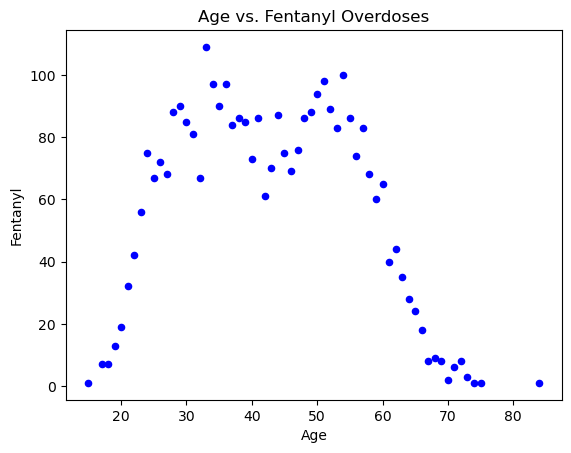

In [40]:
age_df.plot(kind="scatter", x="Age", y="Fentanyl", color="blue")
plt.title("Age vs. Fentanyl Overdoses")

plt.savefig("Images/AgeVsFentanyl.png")